In [ ]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import normaltest, shapiro
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import bds

In [ ]:
lags = [7, 14, 21, 28]
residuals_dict = {}

for lag in lags:
    bundle = joblib.load(f"../app/model_lag{lag}.joblib")
    info = bundle["info"]
    y_true = np.array(info["reals"])
    y_pred = np.array(info["preds"])
    residuals = y_true - y_pred
    residuals_dict[lag] = residuals

# **Diagnóstico de los Residuos por Horizonte de Pronóstico**

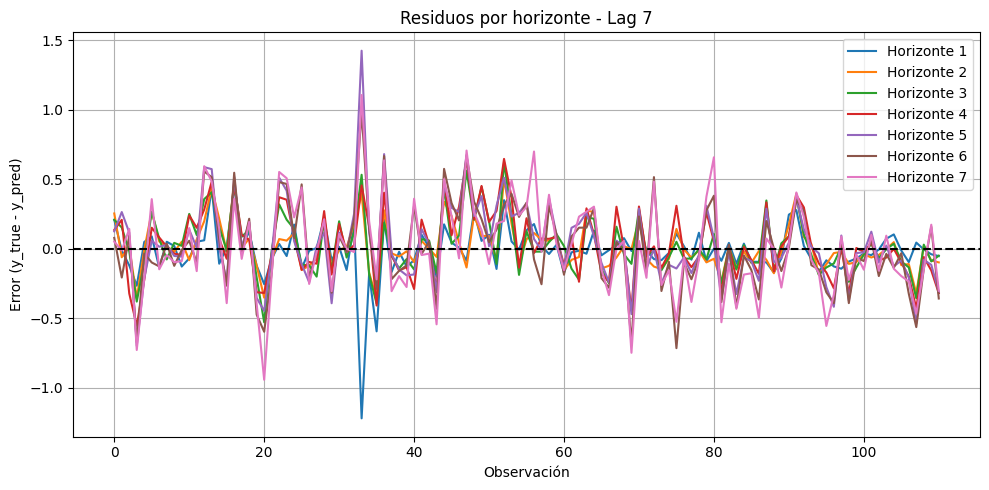

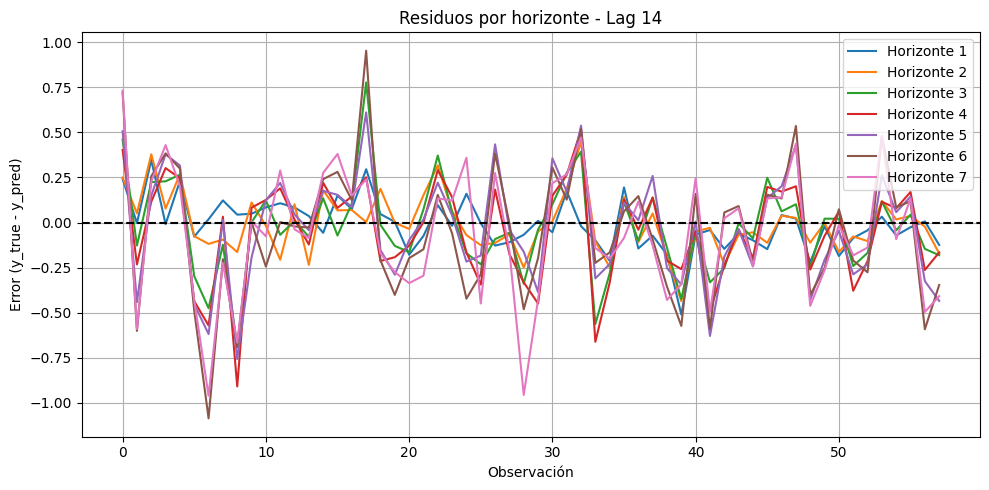

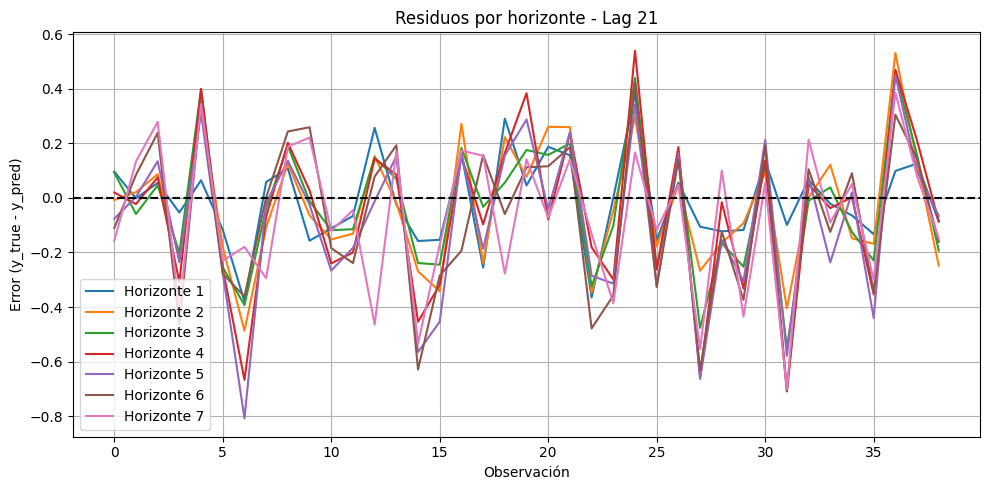

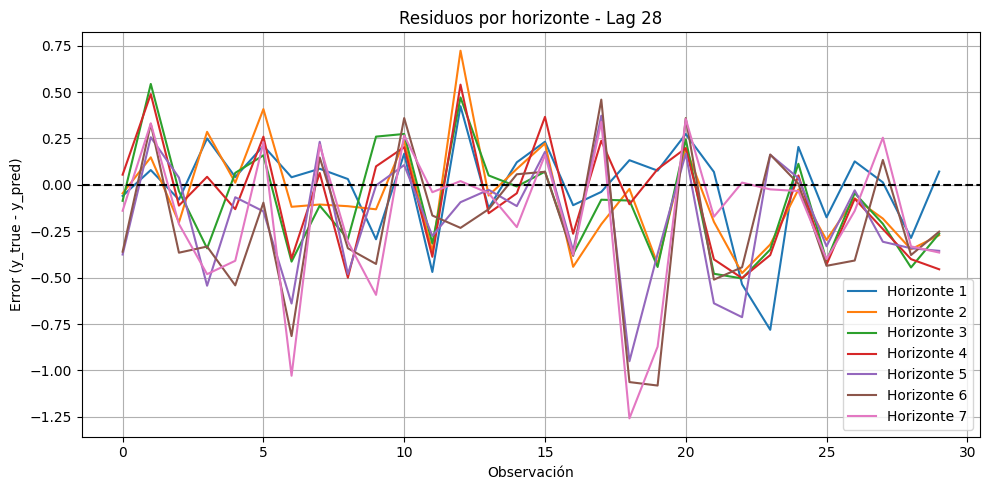

In [50]:
for lag, residuals in residuals_dict.items():
    plt.figure(figsize=(10, 5))
    for h in range(residuals.shape[1]):
        plt.plot(residuals[:, h], label=f"Horizonte {h+1}")
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f"Residuos por horizonte - Lag {lag}")
    plt.xlabel("Observación")
    plt.ylabel("Error (y_true - y_pred)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


El objetivo de estos gráficos es evaluar si los errores (**residuos**) de cada modelo se comportan de manera aleatoria a lo largo del tiempo. Un buen modelo debería mostrar residuos que oscilen alrededor de cero sin patrones sistemáticos.


##  Modelos de 7 y 14 Días — Buen Comportamiento
- Los residuos están centrados en **cero** y fluctúan de forma aparentemente aleatoria.  
- No se observan **tendencias ni ciclos evidentes**.  
- Indican que estos modelos han capturado con éxito la estructura predecible de la serie, dejando solo **ruido blanco**.  


##  Modelos de 21 y 28 Días — Rendimiento Inferior
- La magnitud de los errores es **visiblemente mayor**.  
- Los residuos muestran **agrupamiento (clustering)**: períodos de errores grandes tienden a ocurrir juntos.  
- Esto refleja una incapacidad para capturar completamente la dinámica de la volatilidad, dejando **patrones predecibles** en los errores.  


##  Conclusión General
- Los modelos con **lags de 7 y 14 días** son los más **robustos y bien especificados**:  
  - Menor error promedio (según métricas de RMSE).  
  - Residuos más aleatorios y consistentes con ruido blanco.  
- En contraste, los modelos de **21 y 28 días** muestran deficiencias en su ajuste y dejan señales no captu

In [51]:
rmse_summary = []

for lag, residuals in residuals_dict.items():
    for h in range(residuals.shape[1]):
        rmse = np.sqrt(np.mean(residuals[:, h]**2))
        rmse_summary.append({
            "Lag": lag,
            "Horizonte": h + 1,
            "RMSE": round(rmse, 4)
        })

rmse_df = pd.DataFrame(rmse_summary)
rmse_df.pivot(index="Lag", columns="Horizonte", values="RMSE")


Horizonte,1,2,3,4,5,6,7
Lag,,,,,,,
7,0.1823,0.1647,0.2059,0.2412,0.2933,0.3082,0.3379
14,0.1398,0.1617,0.2497,0.2808,0.3042,0.3709,0.3564
21,0.1616,0.2264,0.2349,0.2998,0.3057,0.3010,0.2750
28,0.2532,0.2763,0.2999,0.3034,0.3692,0.4418,0.4310


# **Normalidad de residuos**

In [52]:
normality_results = []

for lag, residuals in residuals_dict.items():
    for h in range(residuals.shape[1]):
        res = residuals[:, h]
        stat_dag, p_dag = normaltest(res)
        stat_shap, p_shap = shapiro(res)
        normality_results.append({
            "Lag": lag,
            "Horizonte": h + 1,
            "D’Agostino p": round(p_dag, 4),
            "Shapiro p": round(p_shap, 4)
        })

pd.DataFrame(normality_results)


,Lag,Horizonte,D’Agostino p,Shapiro p
0,7,1,0.0000,0.0000
1,7,2,0.0028,0.0002
2,7,3,0.0390,0.0264
3,7,4,0.5399,0.5476
4,7,5,0.0000,0.0002
5,7,6,0.4163,0.7272
6,7,7,0.2818,0.6348
7,14,1,0.0417,0.0638
8,14,2,0.1581,0.3667
9,14,3,0.0941,0.4064


El objetivo de esta prueba es determinar si los errores (**residuos**) del modelo siguen una distribución normal. Un **p-valor alto (> 0.05)** indica que los residuos no difieren significativamente de la normalidad, lo cual es deseable porque implica que el modelo ha capturado de forma adecuada la naturaleza estocástica de los datos.


##  Modelos de 14 y 21 Días — Residuos Estadísticamente Robustos

- **Modelo de 21 días (Mejor Comportamiento Diagnóstico):**  
  - Supera la prueba de normalidad en todos los horizontes.  
  - Sus residuos presentan p-valores consistentemente altos.  
  - Los errores se asemejan a una distribución gaussiana bien definida.  

- **Modelo de 14 días (Excelente Comportamiento):**  
  - Residuos normales en casi todos los horizontes.  
  - Únicamente muestra un resultado limítrofe en el **horizonte de 1 día**.  

##  Modelos de 7 y 28 Días — Residuos No Normales

- **Modelo de 7 días:**  
  - Aunque es el más preciso en términos de **RMSE**, falla la prueba de normalidad en los horizontes **1, 2, 3 y 5 días**.  
  - Sus p-valores son prácticamente cero, lo que indica residuos con distribución no normal.  

- **Modelo de 28 días:**  
  - Presenta problemas en el **horizonte 1**.  
  - En el horizonte 7 falla específicamente la prueba de **Shapiro-Wilk**, confirmando que sus residuos no son normales.  


##  Síntesis: Precisión vs. Normalidad

Estos resultados ponen de manifiesto un **compromiso clásico en series temporales financieras**:

- **Modelo de 7 días → Máxima precisión predictiva (menor RMSE):**  
  - Captura de manera más fiel la magnitud de la volatilidad.  
  - Sin embargo, al enfrentarse a eventos extremos (colas pesadas), los residuos resultan **no normales**.  

- **Modelo de 21 días → Menor precisión, mayor normalidad:**  
  - Sus predicciones son excesivamente suavizadas.  
  - Este efecto de suavizado hace que los residuos se acerquen más a una **distribución normal**, aunque con menor poder predictivo.  


#  **ACF**

<Figure size 600x300 with 0 Axes>

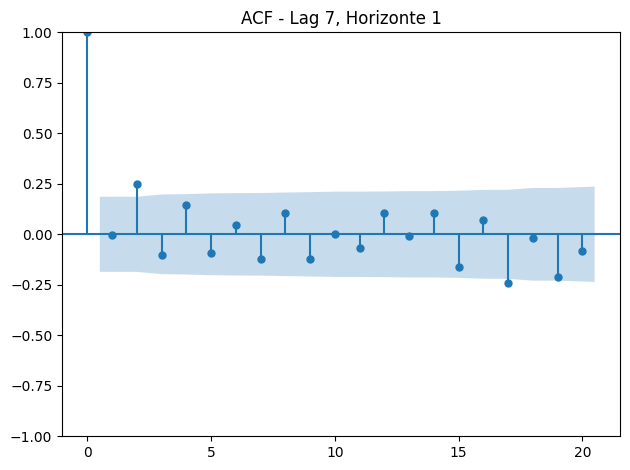

<Figure size 600x300 with 0 Axes>

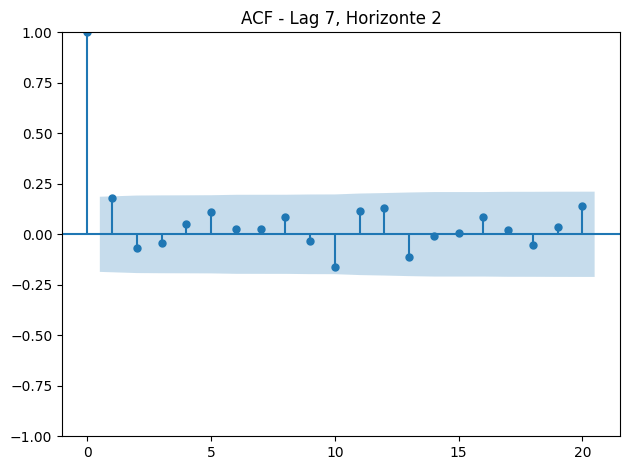

<Figure size 600x300 with 0 Axes>

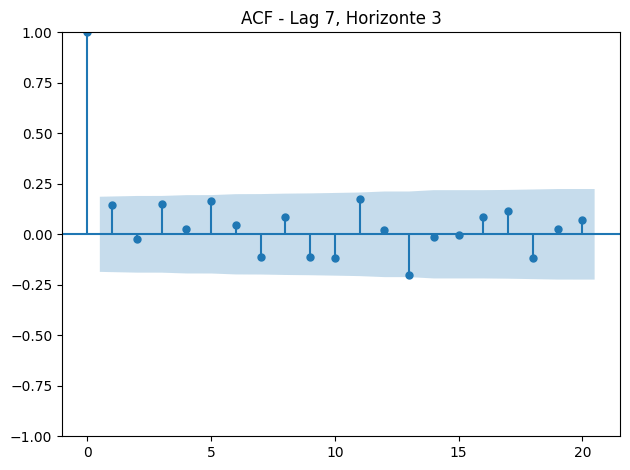

<Figure size 600x300 with 0 Axes>

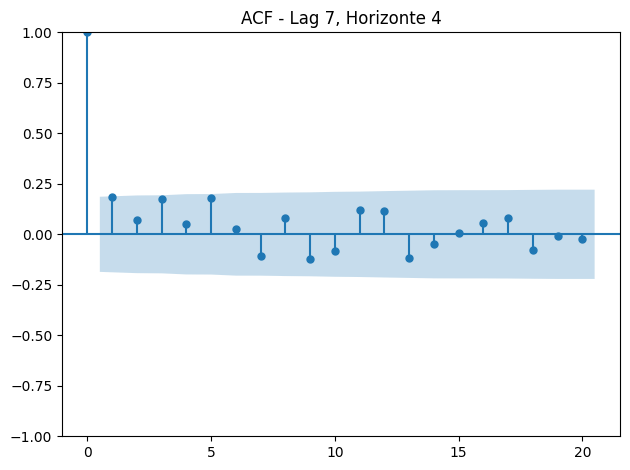

<Figure size 600x300 with 0 Axes>

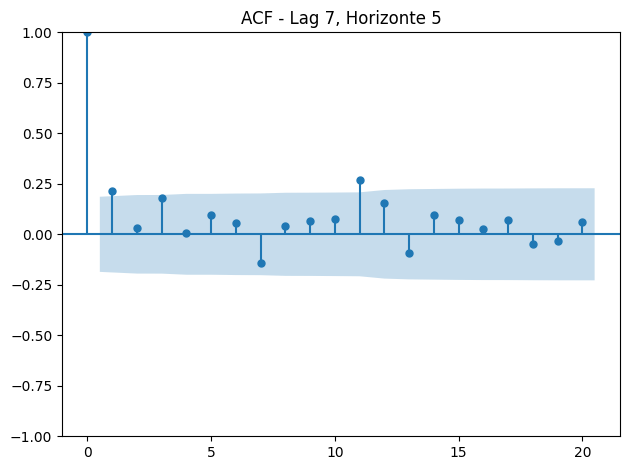

<Figure size 600x300 with 0 Axes>

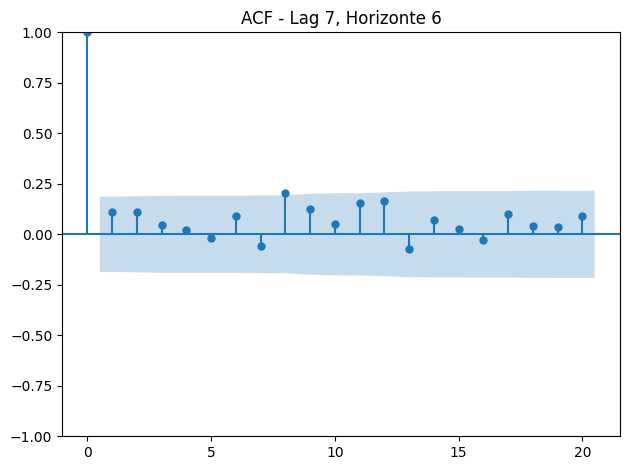

<Figure size 600x300 with 0 Axes>

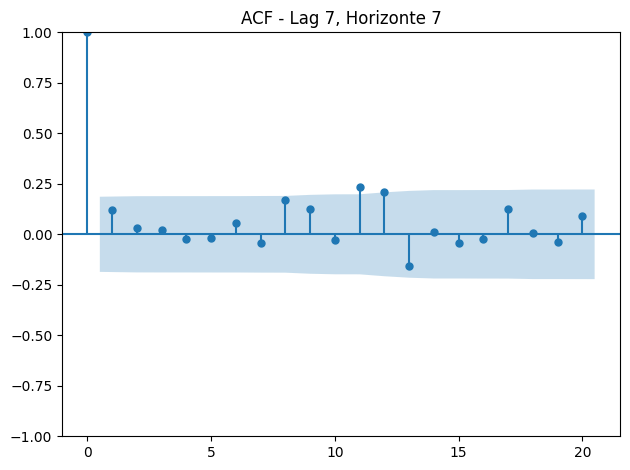

<Figure size 600x300 with 0 Axes>

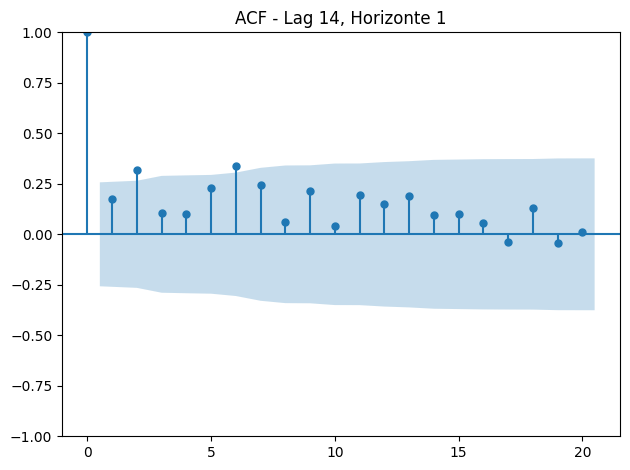

<Figure size 600x300 with 0 Axes>

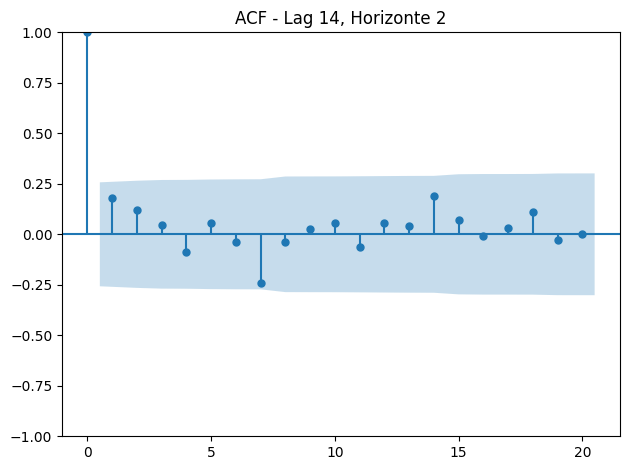

<Figure size 600x300 with 0 Axes>

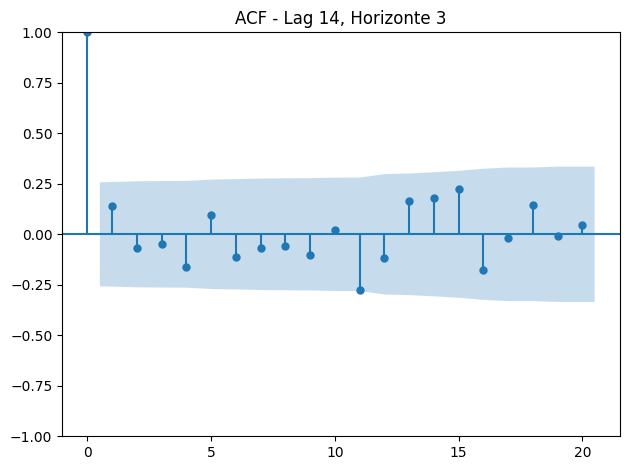

<Figure size 600x300 with 0 Axes>

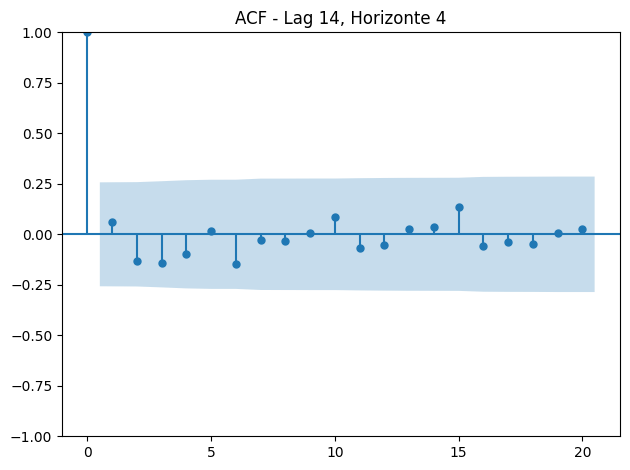

<Figure size 600x300 with 0 Axes>

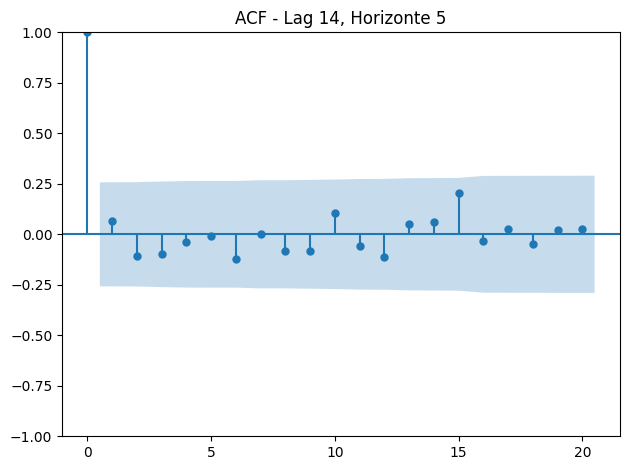

<Figure size 600x300 with 0 Axes>

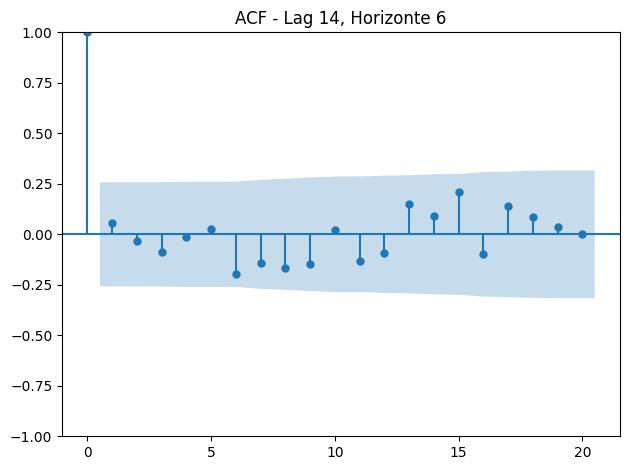

<Figure size 600x300 with 0 Axes>

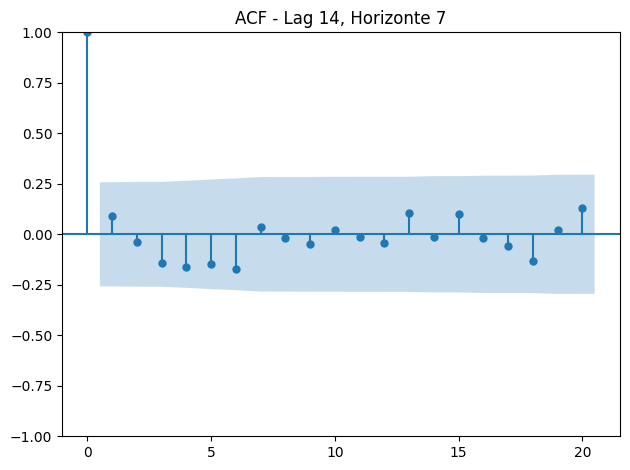

<Figure size 600x300 with 0 Axes>

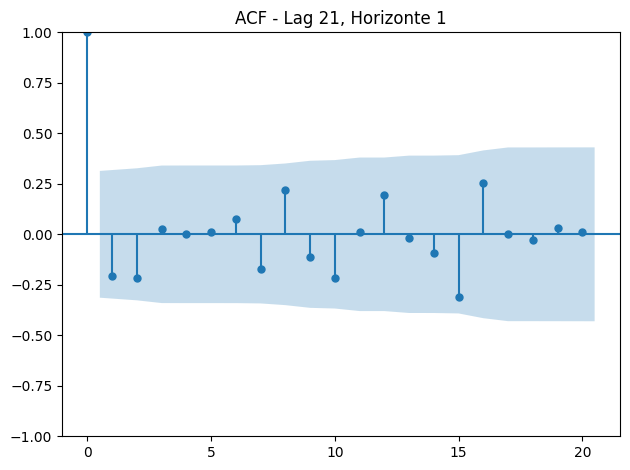

<Figure size 600x300 with 0 Axes>

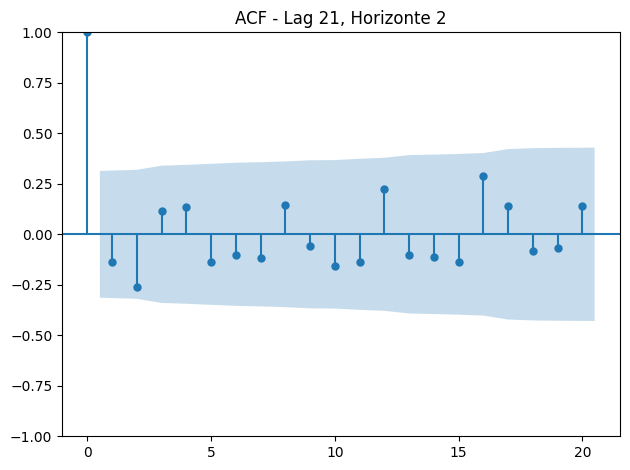

<Figure size 600x300 with 0 Axes>

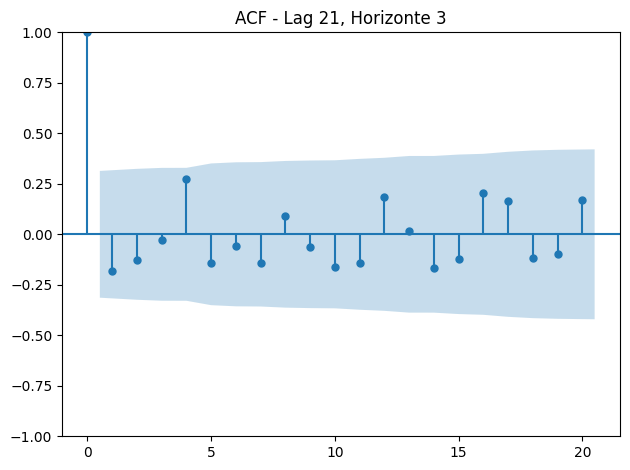

<Figure size 600x300 with 0 Axes>

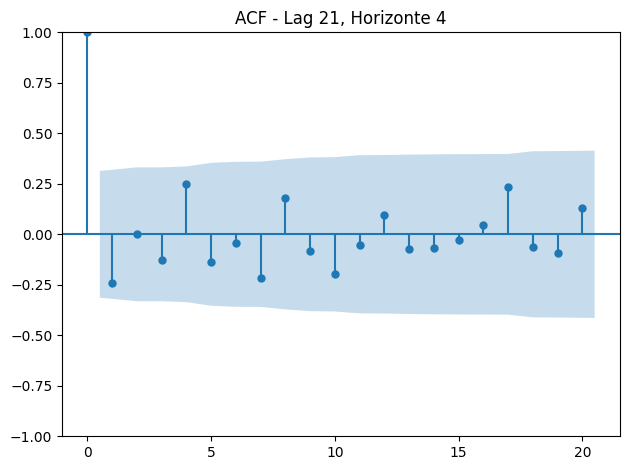

<Figure size 600x300 with 0 Axes>

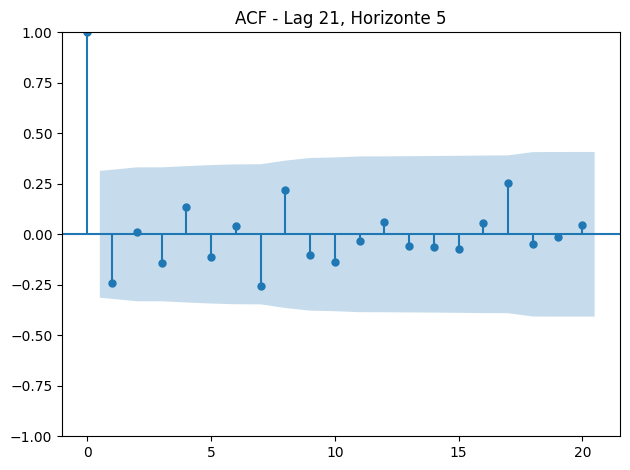

<Figure size 600x300 with 0 Axes>

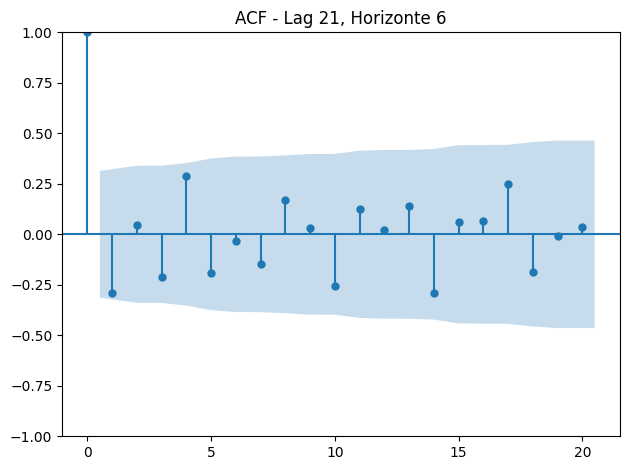

<Figure size 600x300 with 0 Axes>

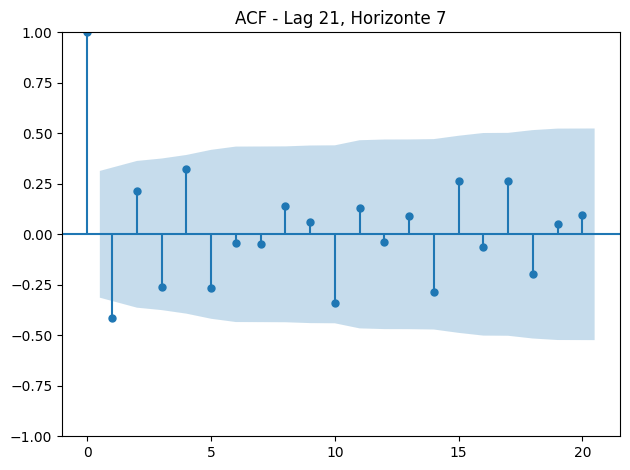

<Figure size 600x300 with 0 Axes>

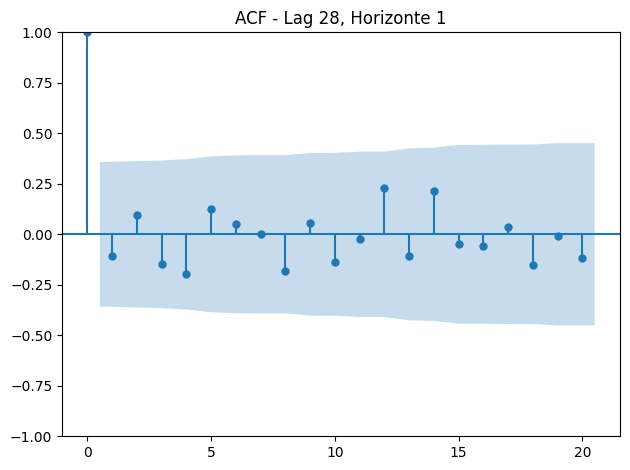

<Figure size 600x300 with 0 Axes>

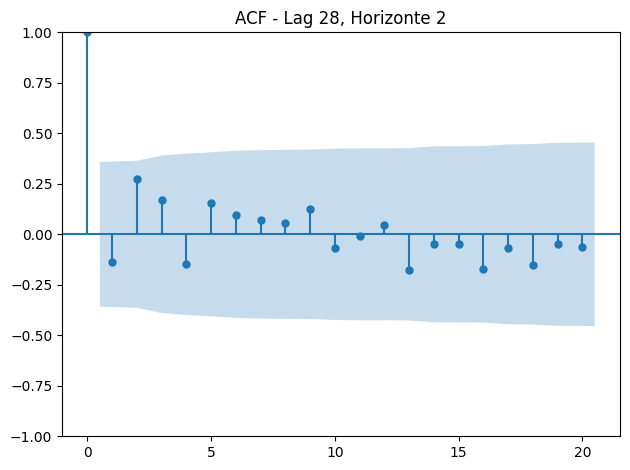

<Figure size 600x300 with 0 Axes>

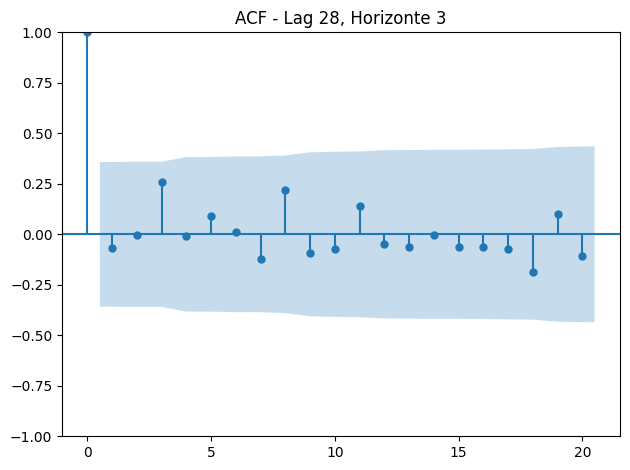

<Figure size 600x300 with 0 Axes>

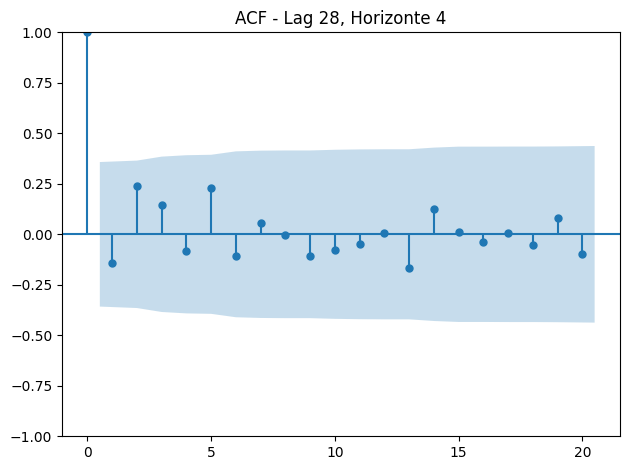

<Figure size 600x300 with 0 Axes>

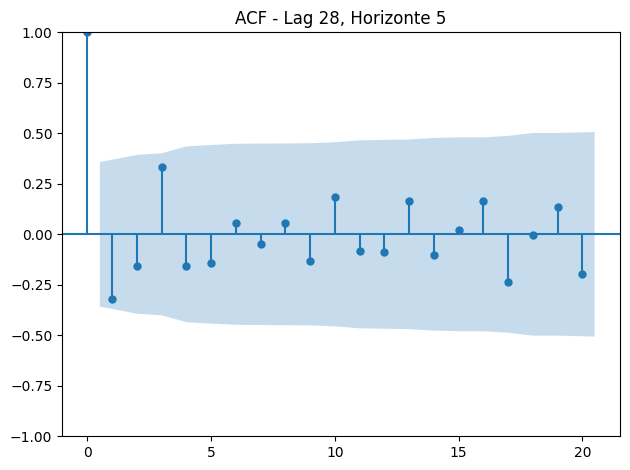

<Figure size 600x300 with 0 Axes>

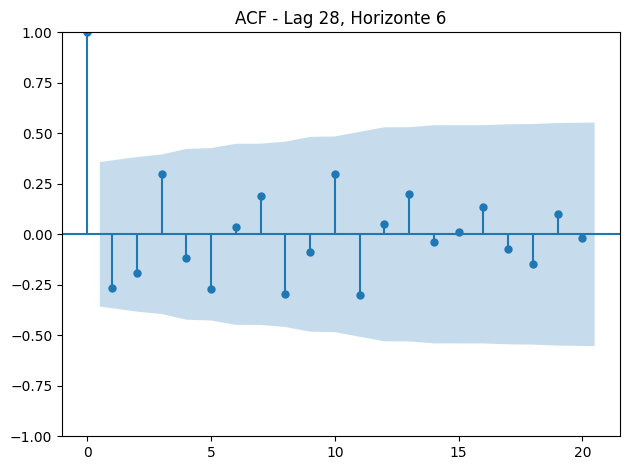

<Figure size 600x300 with 0 Axes>

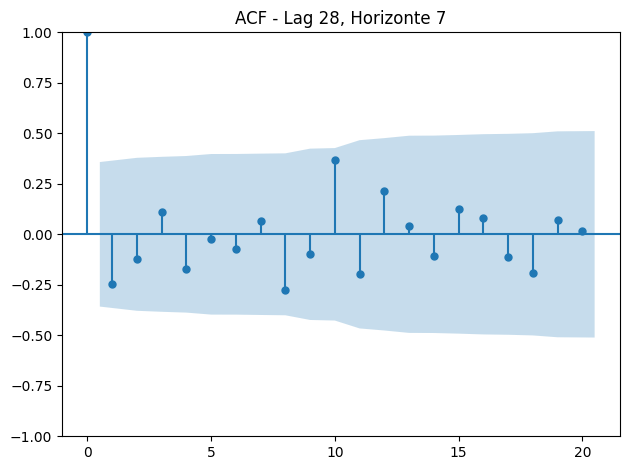

In [53]:
for lag, residuals in residuals_dict.items():
    for h in range(residuals.shape[1]):
        plt.figure(figsize=(6, 3))
        plot_acf(residuals[:, h], lags=20)
        plt.title(f"ACF - Lag {lag}, Horizonte {h+1}")
        plt.tight_layout()
        plt.show()
